**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 51kB 3.6MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [3]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0

Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170500096/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)



Next we will construct a **Base Model**, which in our case is a small CNN.

In [4]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#print(model.vars())
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



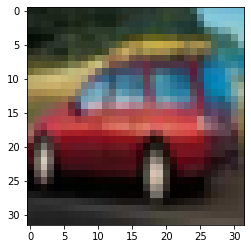

In [5]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [7]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

#print("my image:",np.shape(my_image))
print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape((filter_weights)))

Filter weights: [[[[ 0.08896715 -0.07279256]
   [ 0.5039943  -0.5607323 ]
   [ 0.69289994 -0.86930597]]]]
Conv output: [[[[ 0.14117865  0.13613605  0.11829102 ...  1.0097966   0.9931872
     0.98468655]
   [ 0.19160458  0.16441517  0.16871695 ...  1.0254501   1.0205964
     1.0155538 ]
   [ 0.19664718  0.16639161  0.19392993 ...  1.0188706   1.0191027
     1.0148438 ]
   ...
   [ 0.22187413  0.21178894  0.21178894 ...  0.27654663  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.3068022   0.30175963
     0.30175963]
   [ 0.1664056   0.161363    0.1664056  ...  0.37739852  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.1958665  -1.1757659
    -1.1652533 ]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.2115611  -1.2058
    -1.1999066 ]
   [-0.22918504 -0.1938243  -0.225776   ... -1.2002045  -1.2009761
    -1.196932  ]
   ...
   [-0.259312   -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346086]
   [-0.21805783 -0.20627

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [8]:
#Solution to the problem PART1.2
conv_output=Conv2d(my_image)

#This is a function for more than 1 number of examples and filter size>1
def my_conv_net(my_image, initial_filter_weights):
  my_conv_output=np.zeros([1,2,32,32])
  stride=1
  filter_size_x=1
  filter_size_y=1
  w=((32-filter_size_x)/stride)+1
  h=((32-filter_size_y)/stride)+1
  for i in range(1): # m # loop over the batch of training examples
     for h in range(32):     #n_H                      # loop over vertical axis of the output volume
            for w in range(32):  #n_W                     # loop over horizontal axis of the output volume
                for c in range(2):   #n_C                # loop over channels (= #filters) of the output volume
                    
                    # Finding the corners of the current "slice" 
                    vert_start  = h * stride
                    vert_end    = vert_start + filter_size_y
                    horiz_start = w * stride
                    horiz_end   = horiz_start + filter_size_x
                    
                    
                    s =np.multiply(my_image[i,:,vert_start:vert_end,horiz_start:horiz_end,].flatten(),(initial_filter_weights[:,:,:,c]).flatten() )
                    my_conv_output[i,c, h, w]  = my_conv_output[i,c, h, w]+np.sum(s)
                 

  return my_conv_output

my_conv_output=my_conv_net(my_image,filter_weights)
print("Convolution output manually computed :", my_conv_output)

#To see that they are equal
#There is just very little difference in the least significant digit
# that's why, np.equal gives wrong result even though the results are basically same
print(my_conv_output.flatten())
print(conv_output.flatten())

Convolution output manually computed : [[[[ 0.14117865  0.13613605  0.11829102 ...  1.00979659  0.9931872
     0.98468654]
   [ 0.19160458  0.16441517  0.16871695 ...  1.02545006  1.02059643
     1.01555384]
   [ 0.19664718  0.16639161  0.19392992 ...  1.01887065  1.01910264
     1.01484388]
   ...
   [ 0.22187412  0.21178893  0.21178893 ...  0.27654664  0.28158923
     0.29671702]
   [ 0.18657596  0.17649078  0.17649078 ...  0.3068022   0.30175961
     0.30175961]
   [ 0.16640559  0.161363    0.16640559 ...  0.37739851  0.37235592
     0.35722814]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.19586641 -1.17576586
    -1.16525327]
   [-0.22329158 -0.19162536 -0.19630872 ... -1.21156101 -1.20580003
    -1.19990658]
   [-0.22918503 -0.19382431 -0.22577599 ... -1.20020451 -1.20097615
    -1.19693196]
   ...
   [-0.25931199 -0.24752508 -0.24752508 ... -0.31988702 -0.32578048
    -0.34346084]
   [-0.21805781 -0.2062709  -0.2062709  ... -0.35524775 -0.34935429
    -0.34935429]
   [-0.1944

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [9]:
#Check that .mean((2,3)) rearranges your image
arr=my_conv_output.mean((2,3))

print(arr)

[[ 0.35491109 -0.41205534]]


Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [10]:
#print("arr:",arr) #Part 1.3
Linear_Layer = objax.nn.Linear(2, 1)
Y = Linear_Layer(arr)


linear_w=Linear_Layer.w.value
print("Linear Layer w value:",linear_w)
linear_b=Linear_Layer.b.value
print("Linear Layer b value:",linear_b)

#This is the part we computed Y that manually implements linear layer
manual_y=sum(arr.flatten()*linear_w.flatten()+linear_b)

#To check the results
print("manually calculated y:",manual_y)
print("Y:",Y)
print("Y values are equal") #again only least significant digits differs, but
#this is just related how it computes the values not methodologic difference


Linear Layer w value: [[-0.17576653]
 [-0.33976567]]
Linear Layer b value: [0.]
manually calculated y: 0.07762077450752258
Y: [[0.07762077]]
Y values are equal


You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [11]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    count=0
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
      
      ####################
    
        
      
      #PUT YOUR CODE HERE#
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [12]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch =train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

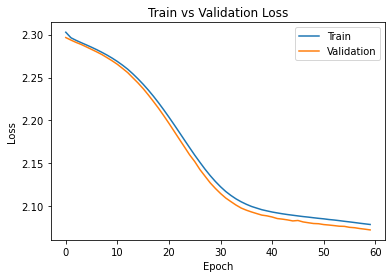

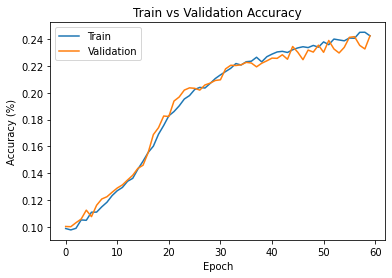

In [13]:

train(EPOCHS = 60, BATCH = 32, LEARNING_RATE = 9e-4) #Part 2 base model with epochs=60

Follow the assignment handout for questions to be answered in this part of the assignment.

In [14]:
class ConvNet2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 128, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(128, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
   
    x = x.mean((2,3)) #<--- global average pooling 

    x = self.linear(x)
    return x

#The following line creates the CNN
model2 = ConvNet2()

In [15]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model2(x)), model2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    print("flags")
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    count=0
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
      
      ####################
    
        
      
      #PUT YOUR CODE HERE#
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [16]:
#Problem 2 part 7, testing my selected model2
def train_last(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  avg_test_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []
  test_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0
      avg_test_loss =  0   # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0 
      test_acc=0       # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch =train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      # run vtest
      test_indices = np.arange(len(X_test)) 
      np.random.shuffle(test_indices)    
      for it in range(0, X_test.shape[0], BATCH):
          batch = test_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          test_prediction = predict(X_test[batch]).argmax(1)
          test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      test_acc_epoch.append(test_acc/X_test.shape[0])
      avg_test_loss_epoch.append(avg_test_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Test Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0],avg_test_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0],100*test_acc/X_test.shape[0]))
  
  #Plot training loss
  plt.title("Train Validation Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.plot(avg_test_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train Validation Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.plot(test_acc_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [ ]:
train_last(EPOCHS = 30, BATCH = 64, LEARNING_RATE = 1e-1) #before running this part please reset 
#to get rid of variables and only run from conv2 model definition

flags
Epoch 0001  Training Loss 2.13 Validation Loss 2.10 Test Loss 2.12 Training Accuracy 25.07 Validation Accuracy 21.22 Test Accuracy 21.43
Epoch 0002  Training Loss 1.96 Validation Loss 1.89 Test Loss 1.91 Training Accuracy 32.75 Validation Accuracy 28.35 Test Accuracy 27.27
Epoch 0003  Training Loss 1.85 Validation Loss 1.75 Test Loss 1.77 Training Accuracy 37.25 Validation Accuracy 35.72 Test Accuracy 33.48
Epoch 0004  Training Loss 1.76 Validation Loss 1.72 Test Loss 1.72 Training Accuracy 40.11 Validation Accuracy 36.48 Test Accuracy 36.48


In [ ]:
class ConvNet3(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 512, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(512, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
   
    x = x.mean((2,3)) #<--- global average pooling 

    x = self.linear(x)
    return x

#The following line creates the CNN
model3 = ConvNet3()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model3(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model3(x)), model3.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model3.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model3.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    print("flag3")
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    count=0
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
      
      ####################
    
        
      
      #PUT YOUR CODE HERE#
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
train(EPOCHS = 60, BATCH = 16, LEARNING_RATE = 1e-2) #similar to above, reset the parameters and run only the part after conv3

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [ ]:
import tensorflow as tf
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data() #picked fashion_mnist dataset,gray coded
X_train = X_train[:,None,:,:] / 255.0
Y_train = Y_train.flatten()
X_test = X_test[:,None,:,:] / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
print(X_data.shape) #in total 70000 examples
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

print(X_train.shape) #56000 training examples

4423680/4422102 [==============================] - 0s 0us/step
(70000, 1, 28, 28)
(56000, 1, 28, 28)


In [ ]:
class ConvNet4(objax.Module): #This is the model that I picked 
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(1, 8, 3), objax.functional.relu])
    
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    
    x=objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x=objax.functional.max_pool_2d(self.conv_3(x), 2, 2)
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model4 = ConvNet4()
#print(model.vars())
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model4(x)
   
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model4(x)), model4.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model4.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model4.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    count=0
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
      
      ####################
    
        
      
      #PUT YOUR CODE HERE#
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 30, BATCH = 32, LEARNING_RATE = 1e-2):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch =train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [ ]:
train_last(EPOCHS = 30, BATCH = 16, LEARNING_RATE = 1e-1) #Q3.4

##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
print(X_train.shape)
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

In [ ]:
class ConvNet2(objax.Module): #I am using the same model that I picked in Part 2 -model2
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 128, 2), objax.functional.relu])
   # self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, 128, 2), objax.functional.relu]) #I tried to add this layer but did not improve so much

    self.linear = objax.nn.Linear(128, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) #max pooling
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2) #max pooling
    x = objax.functional.average_pool_2d(self.conv_3(x), 2, 2) #average pooling
    #x = objax.functional.average_pool_2d(self.conv_4(x), 2, 2)
    x = x.mean((2,3)) #<--- global average pooling 

    x = self.linear(x)
    return x

#The following line creates the CNN
model2 = ConvNet2()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model2(x)), model2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    count=0
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      
      
      ####################
      params.value -= lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
#Problem 2 part 7, testing my selected model2
def train_last(EPOCHS = 30, BATCH = 64, LEARNING_RATE = 1e-1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  avg_test_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []
  test_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0
      avg_test_loss =  0   # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0 
      test_acc=0       # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch =train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      # run vtest
      test_indices = np.arange(len(X_test)) 
      np.random.shuffle(test_indices)    
      for it in range(0, X_test.shape[0], BATCH):
          batch = test_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          test_prediction = predict(X_test[batch]).argmax(1)
          test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      test_acc_epoch.append(test_acc/X_test.shape[0])
      avg_test_loss_epoch.append(avg_test_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Test Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0],avg_test_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0],100*test_acc/X_test.shape[0]))
  
  #Plot training loss
  plt.title("Train Validation Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.plot(avg_test_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train Validation Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.plot(test_acc_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [ ]:
train_last(EPOCHS = 30, BATCH = 64, LEARNING_RATE = e-1)